In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Outlier Detection Analysis with Pokemon Dataset

In [18]:
df = pd.read_csv('Pokemon.csv')

df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


In [19]:
df = pd.read_csv('Pokemon.csv')

df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [20]:
df.info()

print("\nMissing values per column:")
print(df.isnull().sum())

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB

Missing values per column:
#               0
Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generatio

,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.00000
mean,362.813750,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500,3.32375
std,208.343798,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474,1.66129
min,1.000000,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.00000
25%,184.750000,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000,2.00000
50%,364.500000,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.00000
75%,539.250000,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.00000
max,721.000000,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.00000


In [21]:
df = df.drop_duplicates()

if '#' in df.columns:
    df = df.drop('#', axis=1)

if 'Legendary' in df.columns:
    df['Legendary'] = df['Legendary'].astype(int)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_numeric = df[numeric_cols]

df_numeric.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
0,318,45,49,49,65,65,45,1
1,405,60,62,63,80,80,60,1
2,525,80,82,83,100,100,80,1
3,625,80,100,123,122,120,80,1
4,309,39,52,43,60,50,65,1


Correlations with 'Total' column:
Sp. Atk       0.747250
Attack        0.736211
Sp. Def       0.717609
HP            0.618748
Defense       0.612787
Speed         0.575943
Generation    0.048384
dtype: float64


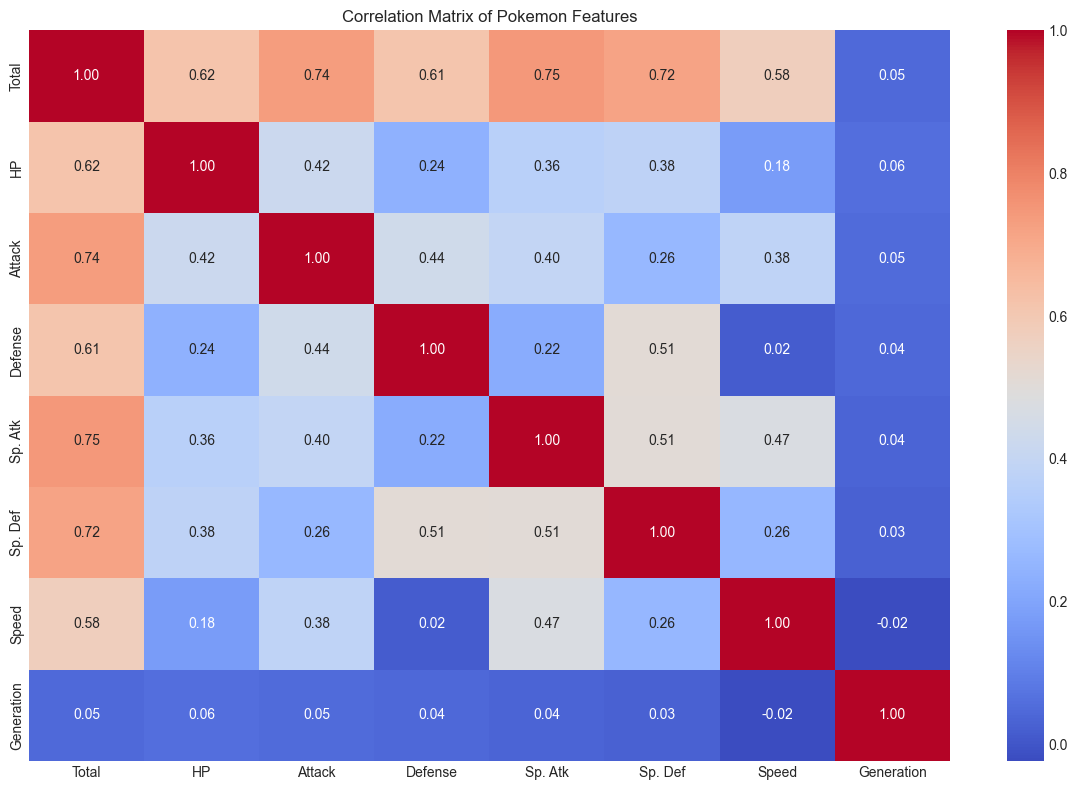


The two columns with highest correlation to Total are: ['Sp. Atk', 'Attack']


,Sp. Atk,Attack
0,65,49
1,80,62
2,100,82
3,122,100
4,60,52


In [22]:
target_col = 'Total'

correlations = df_numeric.drop(target_col, axis=1).corrwith(df_numeric[target_col]).sort_values(ascending=False)

print("Correlations with '{}' column:".format(target_col))
print(correlations)

plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Pokemon Features')
plt.tight_layout()
plt.show()

top_cols = correlations.abs().nlargest(2).index.tolist()
print(f"\nThe two columns with highest correlation to {target_col} are: {top_cols}")

subset_df = df_numeric[top_cols]
subset_df.head()

In [23]:
contamination = 0.1

isolation_forest = IsolationForest(contamination=contamination, random_state=42)
one_class_svm = OneClassSVM(nu=contamination)
elliptic_envelope = EllipticEnvelope(contamination=contamination, random_state=42)
lof = LocalOutlierFactor(contamination=contamination, n_neighbors=20)

isolation_forest.fit(subset_df)
isf_predictions = isolation_forest.predict(subset_df)

one_class_svm.fit(subset_df)
ocsvm_predictions = one_class_svm.predict(subset_df)

elliptic_envelope.fit(subset_df)
ee_predictions = elliptic_envelope.predict(subset_df)

lof_predictions = lof.fit_predict(subset_df)

isf_outliers = np.where(isf_predictions == -1, 0, 1)
ocsvm_outliers = np.where(ocsvm_predictions == -1, 0, 1)
ee_outliers = np.where(ee_predictions == -1, 0, 1)
lof_outliers = np.where(lof_predictions == -1, 0, 1)

results_df = pd.DataFrame({
    top_cols[0]: subset_df[top_cols[0]],
    top_cols[1]: subset_df[top_cols[1]],
    'Isolation Forest': isf_outliers,
    'One-Class SVM': ocsvm_outliers,
    'Elliptic Envelope': ee_outliers,
    'Local Outlier Factor': lof_outliers
})

print(f"Number of outliers detected by each algorithm with contamination={contamination}:")
print(f"Isolation Forest: {(isf_outliers == 0).sum()}")
print(f"One-Class SVM: {(ocsvm_outliers == 0).sum()}")
print(f"Elliptic Envelope: {(ee_outliers == 0).sum()}")
print(f"Local Outlier Factor: {(lof_outliers == 0).sum()}")

Number of outliers detected by each algorithm with contamination=0.1:
Isolation Forest: 80
One-Class SVM: 80
Elliptic Envelope: 80
Local Outlier Factor: 80


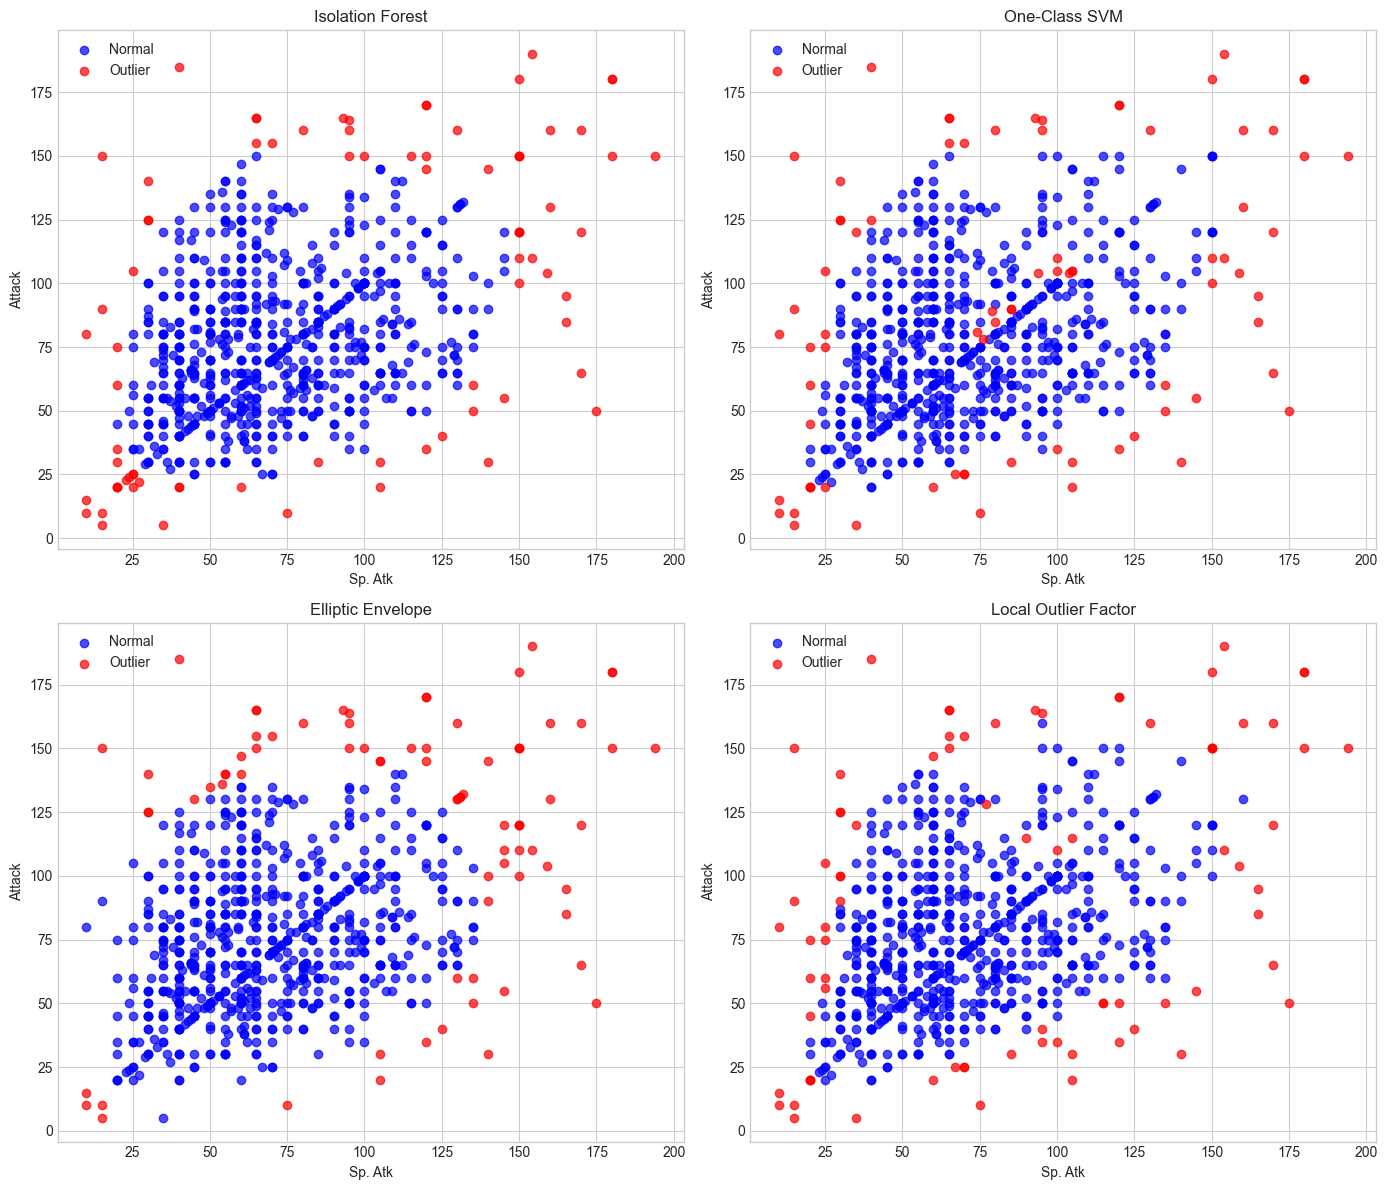

Analysis of outlier detection algorithms:
1. Isolation Forest: Tends to identify data points in sparse regions as outliers.
2. One-Class SVM: Creates a boundary and identifies points outside it as outliers.
3. Elliptic Envelope: Assumes a Gaussian distribution and finds points far from the center.
4. Local Outlier Factor: Detects outliers based on local density deviations.


In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

algorithms = ['Isolation Forest', 'One-Class SVM', 'Elliptic Envelope', 'Local Outlier Factor']
predictions = [isf_outliers, ocsvm_outliers, ee_outliers, lof_outliers]

for i, (algorithm, prediction) in enumerate(zip(algorithms, predictions)):
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    inlier_mask = prediction == 1
    outlier_mask = prediction == 0
    
    ax.scatter(subset_df[top_cols[0]][inlier_mask], subset_df[top_cols[1]][inlier_mask], 
               c='blue', label='Normal', alpha=0.7)
    ax.scatter(subset_df[top_cols[0]][outlier_mask], subset_df[top_cols[1]][outlier_mask], 
               c='red', label='Outlier', alpha=0.7)
    
    ax.set_title(algorithm)
    ax.set_xlabel(top_cols[0])
    ax.set_ylabel(top_cols[1])
    ax.legend()

plt.tight_layout()
plt.show()

print("Analysis of outlier detection algorithms:")
print("1. Isolation Forest: Tends to identify data points in sparse regions as outliers.")
print("2. One-Class SVM: Creates a boundary and identifies points outside it as outliers.")
print("3. Elliptic Envelope: Assumes a Gaussian distribution and finds points far from the center.")
print("4. Local Outlier Factor: Detects outliers based on local density deviations.")

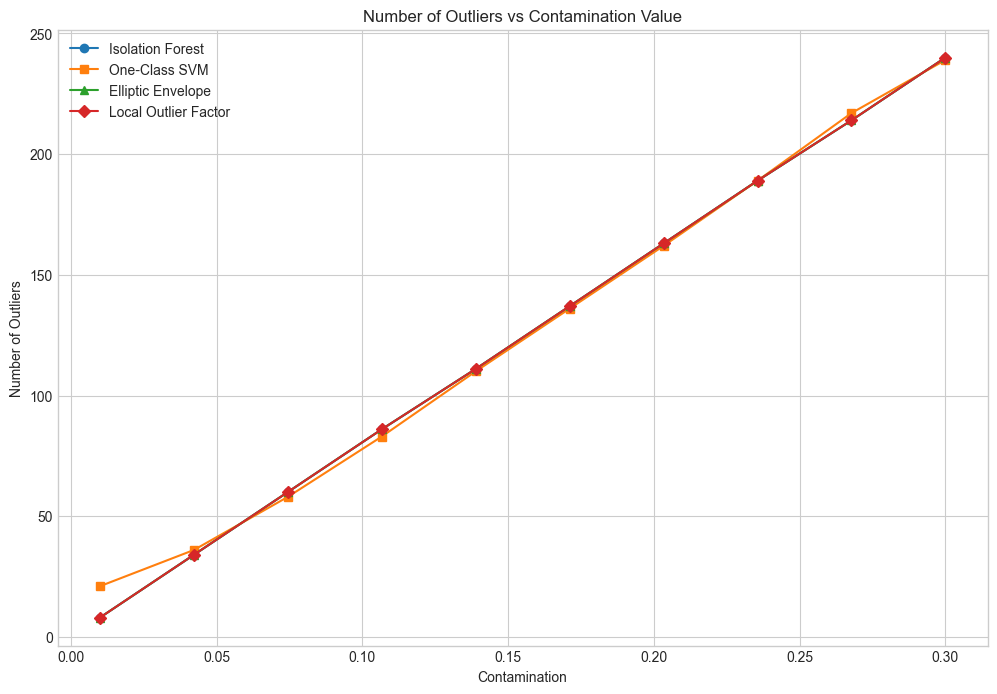

Conclusions:
1. As contamination increases, more data points are classified as outliers.
2. Different algorithms may respond differently to contamination parameter changes.
3. The relationship between contamination and number of outliers is generally linear for most algorithms.


In [25]:
X = df_numeric.drop(target_col, axis=1)

contamination_values = np.linspace(0.01, 0.3, 10)

isf_outliers_count = []
ocsvm_outliers_count = []
ee_outliers_count = []
lof_outliers_count = []

for contamination in contamination_values:
    isf = IsolationForest(contamination=contamination, random_state=42)
    isf_pred = isf.fit_predict(X)
    isf_outliers_count.append((isf_pred == -1).sum())
    
    ocsvm = OneClassSVM(nu=contamination)
    ocsvm_pred = ocsvm.fit_predict(X)
    ocsvm_outliers_count.append((ocsvm_pred == -1).sum())
    
    ee = EllipticEnvelope(contamination=contamination, random_state=42)
    ee_pred = ee.fit_predict(X)
    ee_outliers_count.append((ee_pred == -1).sum())
    
    lof = LocalOutlierFactor(contamination=contamination, n_neighbors=20)
    lof_pred = lof.fit_predict(X)
    lof_outliers_count.append((lof_pred == -1).sum())

plt.figure(figsize=(12, 8))
plt.plot(contamination_values, isf_outliers_count, 'o-', label='Isolation Forest')
plt.plot(contamination_values, ocsvm_outliers_count, 's-', label='One-Class SVM')
plt.plot(contamination_values, ee_outliers_count, '^-', label='Elliptic Envelope')
plt.plot(contamination_values, lof_outliers_count, 'D-', label='Local Outlier Factor')

plt.xlabel('Contamination')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers vs Contamination Value')
plt.legend()
plt.grid(True)
plt.show()

print("Conclusions:")
print("1. As contamination increases, more data points are classified as outliers.")
print("2. Different algorithms may respond differently to contamination parameter changes.")
print("3. The relationship between contamination and number of outliers is generally linear for most algorithms.")

In [26]:
X = df_numeric.drop(target_col, axis=1)
y = df_numeric[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

contamination = 0.1

isf = IsolationForest(contamination=contamination, random_state=42)
ocsvm = OneClassSVM(nu=contamination)
ee = EllipticEnvelope(contamination=contamination, random_state=42)
lof = LocalOutlierFactor(contamination=contamination, n_neighbors=20)

isf.fit(X_train)
isf_mask = isf.predict(X_train) == 1
X_train_isf = X_train[isf_mask]
y_train_isf = y_train[isf_mask]

ocsvm.fit(X_train)
ocsvm_mask = ocsvm.predict(X_train) == 1
X_train_ocsvm = X_train[ocsvm_mask]
y_train_ocsvm = y_train[ocsvm_mask]

ee.fit(X_train)
ee_mask = ee.predict(X_train) == 1
X_train_ee = X_train[ee_mask]
y_train_ee = y_train[ee_mask]

lof_mask = lof.fit_predict(X_train) == 1
X_train_lof = X_train[lof_mask]
y_train_lof = y_train[lof_mask]

print(f"Original training set size: {len(X_train)}")
print(f"After Isolation Forest: {len(X_train_isf)} ({len(X_train_isf)/len(X_train):.2%})")
print(f"After One-Class SVM: {len(X_train_ocsvm)} ({len(X_train_ocsvm)/len(X_train):.2%})")
print(f"After Elliptic Envelope: {len(X_train_ee)} ({len(X_train_ee)/len(X_train):.2%})")
print(f"After Local Outlier Factor: {len(X_train_lof)} ({len(X_train_lof)/len(X_train):.2%})")

Original training set size: 560
After Isolation Forest: 504 (90.00%)
After One-Class SVM: 506 (90.36%)
After Elliptic Envelope: 504 (90.00%)
After Local Outlier Factor: 504 (90.00%)


In [27]:
models = {
    'Linear Regression': LinearRegression(),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5)
}

datasets = {
    'Original': (X_train, y_train),
    'Isolation Forest': (X_train_isf, y_train_isf),
    'One-Class SVM': (X_train_ocsvm, y_train_ocsvm),
    'Elliptic Envelope': (X_train_ee, y_train_ee),
    'Local Outlier Factor': (X_train_lof, y_train_lof)
}

results = []

for model_name, model in models.items():
    for dataset_name, (X_train_clean, y_train_clean) in datasets.items():
        model.fit(X_train_clean, y_train_clean)
        
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        
        results.append({
            'Model': model_name,
            'Outlier Detection': dataset_name,
            'MSE': mse,
            'RMSE': rmse,
            'R²': r2
        })

results_df = pd.DataFrame(results)
pivot_mse = results_df.pivot(index='Model', columns='Outlier Detection', values='MSE')
pivot_r2 = results_df.pivot(index='Model', columns='Outlier Detection', values='R²')

print("Mean Squared Error (MSE) - Lower is better:")
print(pivot_mse)
print("\nR² Score - Higher is better:")
print(pivot_r2)

Mean Squared Error (MSE) - Lower is better:
Outlier Detection  Elliptic Envelope  Isolation Forest  Local Outlier Factor  \
Model                                                                          
KNN Regressor           2.729498e+02      4.561080e+02          4.015355e+02   
Linear Regression       4.803006e-27      5.439143e-27          2.278651e-26   

Outlier Detection  One-Class SVM      Original  
Model                                           
KNN Regressor       4.166510e+02  3.387805e+02  
Linear Regression   2.169599e-26  2.192823e-26  

R² Score - Higher is better:
Outlier Detection  Elliptic Envelope  Isolation Forest  Local Outlier Factor  \
Model                                                                          
KNN Regressor               0.980176          0.966874              0.970837   
Linear Regression           1.000000          1.000000              1.000000   

Outlier Detection  One-Class SVM  Original  
Model                                      

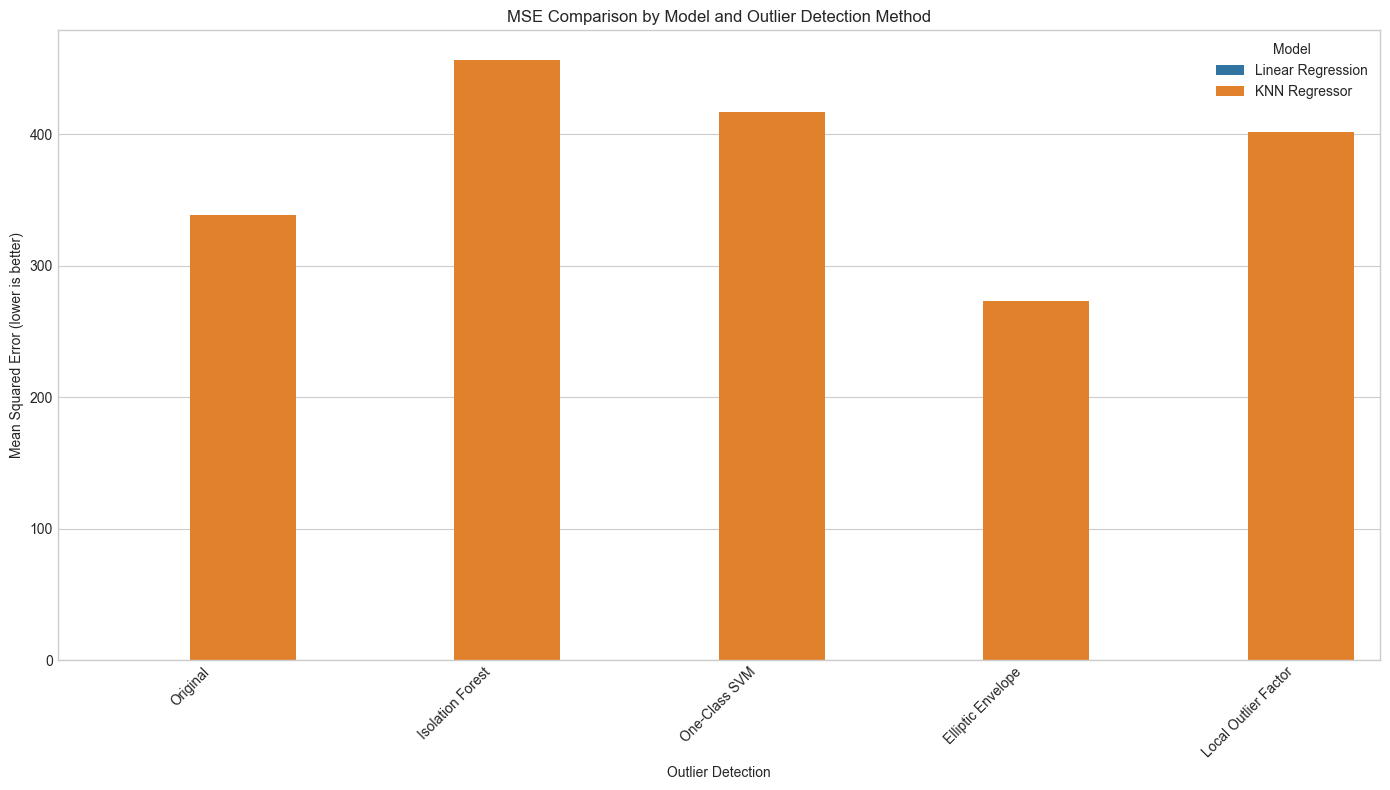

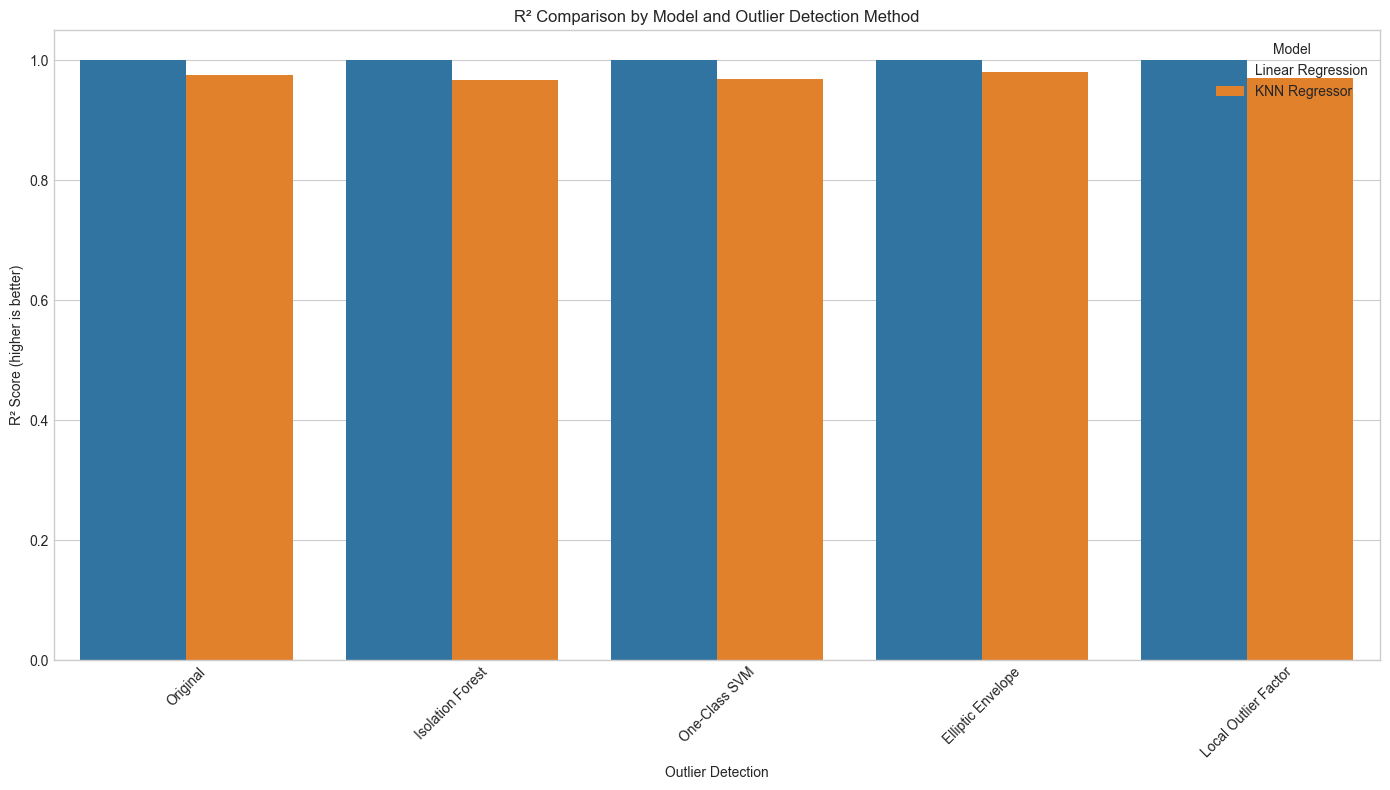

In [28]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Outlier Detection', y='MSE', hue='Model', data=results_df)
plt.title('MSE Comparison by Model and Outlier Detection Method')
plt.xticks(rotation=45)
plt.ylabel('Mean Squared Error (lower is better)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='Outlier Detection', y='R²', hue='Model', data=results_df)
plt.title('R² Comparison by Model and Outlier Detection Method')
plt.xticks(rotation=45)
plt.ylabel('R² Score (higher is better)')
plt.tight_layout()
plt.show()